In [3]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


#Reading Data from CSV Files
temperature_readings = pd.read_csv('data/W512_readings_floorplan1.csv') #original dataset for temp readings 
temperature_readings = temperature_readings.interpolate(method='linear')#fill in null values


weather_readings = pd.read_csv('data/weatherData.csv') #orignal dataset for weather readings

# Converting date and time in temperature_readings to UNIX timestamp for comparision 
temperature_readings['datetime_str'] = temperature_readings['date'] + ' ' + temperature_readings['time']
temperature_readings['datetime'] = temperature_readings['datetime_str'].apply(lambda x: datetime.strptime(x, "%a %b %d %Y %I:%M:%S %p"))
temperature_readings['unix_timestamp'] = temperature_readings['datetime'].apply(lambda x: int(x.timestamp()))

# Converting date and time in weather_readings to UNIX timestamp for comparision 
weather_readings['datetime_str'] = weather_readings['date'] + ' ' + weather_readings['time']
weather_readings['datetime'] = weather_readings['datetime_str'].apply(lambda x: datetime.strptime(x, "%a %b %d %Y %I:%M:%S %p"))
weather_readings['unix_timestamp'] = weather_readings['datetime'].apply(lambda x: int(x.timestamp()))

weather_result_col = [col for col in weather_readings.columns if "result" in col.lower()]

# Merging both data for it to be on the same time
merged_data = pd.merge_asof(
    temperature_readings,  # Left DataFrame
    weather_readings[['unix_timestamp']+weather_result_col],      # Right DataFrame
    on='unix_timestamp',   # Key column
    direction='nearest'    # Match the nearest time
)

datetime_string = merged_data['date'] + " " + merged_data["time"]
merged_data["ISO_formatted_datetime"] = pd.to_datetime(
    datetime_string,
    format="%a %b %d %Y %I:%M:%S %p"
)


# #Columns for lorWan Sensors
temperature_col = [
    col for col in merged_data.columns 
    if "lorawan_readings" in col.lower() and "temperature" in col.lower()
]

humidity_col = [
    col for col in merged_data.columns 
    if "humidity" in col.lower() and "lorawan_readings" in col.lower()
]

co2_col = [
    col for col in merged_data.columns 
    if "co2" in col.lower() and "lorawan_readings" in col.lower()
]

sensors_to_keep = ["Sensor_1", "Sensor_3", "Sensor_6"]
sensors_col = [col for col in merged_data.columns if any(sensor in col for sensor in sensors_to_keep)]

weather_cols_to_keep = ["weather_status","weather_temp","weather_humidity"]
weather_col = [col for col in merged_data.columns if any(weathercol in col for weathercol in weather_cols_to_keep)]

#adding avg temp humid and co2
merged_data['avg_temperature'] = merged_data[temperature_col].median(axis=1)
merged_data['avg_humidity'] = merged_data[humidity_col].mean(axis=1)
merged_data['avg_co2'] = merged_data[co2_col].mean(axis=1)

avg_col = [
    col for col in merged_data.columns
    if "avg" in col.lower()
]

#Energy(power,energy,current) Data
energy_data = merged_data[["ISO_formatted_datetime"]+ sensors_col]
energy_data.columns = energy_data.columns.str.replace(
    r"Energy_Readings.Sensor_1\.(Current|Energy|Power)", "compressor_\\1", regex=True
).str.replace(
    r"Energy_Readings.Sensor_3\.(Current|Energy|Power)", "fancoil_1_\\1", regex=True
).str.replace(
    r"Energy_Readings.Sensor_6\.(Current|Energy|Power)", "fancoil_2_\\1", regex=True
)

#indoor Data
indoor_data = merged_data[["ISO_formatted_datetime"] + temperature_col + humidity_col + co2_col + avg_col]


#Weather data
weather_data = merged_data[["ISO_formatted_datetime"]+ weather_col]
weather_data.columns = weather_data.columns.str.replace(
    r"result.weather_status", "weather_status", regex=True
).str.replace(
    r"result.weather_temp", "weather_temp", regex=True
).str.replace(
    r"result.weather_humidity", "weather_humidity", regex=True
)


#merging all the needed data
energy_indoor_merged = pd.merge(energy_data, indoor_data, on='ISO_formatted_datetime', how='inner')
final_merged_data = pd.merge(energy_indoor_merged, weather_data, on='ISO_formatted_datetime', how='inner')

final_merged_data['total_energy'] = (
    final_merged_data['compressor_Energy'] +
    final_merged_data['fancoil_1_Energy'] +
    final_merged_data['fancoil_2_Energy']
)

final_merged_data['total_power'] = (
    final_merged_data['compressor_Power'] +
    final_merged_data['fancoil_1_Power'] +
    final_merged_data['fancoil_2_Power']
)

final_merged_data['total_current'] = (
    final_merged_data['compressor_Current'] +
    final_merged_data['fancoil_1_Current'] +
    final_merged_data['fancoil_2_Current']
)


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


print(final_merged_data.info())
print(final_merged_data.isnull().any())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3232 entries, 0 to 3231
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype         
---  ------                                         --------------  -----         
 0   ISO_formatted_datetime                         3232 non-null   datetime64[ns]
 1   compressor_Current                             3232 non-null   float64       
 2   compressor_Energy                              3232 non-null   float64       
 3   compressor_Power                               3232 non-null   float64       
 4   fancoil_1_Current                              3232 non-null   float64       
 5   fancoil_1_Energy                               3232 non-null   float64       
 6   fancoil_1_Power                                3232 non-null   float64       
 7   fancoil_2_Current                              3232 non-null   float64       
 8   fancoil_2_Energy                               3232 non-nu

C:\Users\Yun Yang\AppData\Local\Temp\ipykernel_4420\449437232.py:20: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  temperature_readings = temperature_readings.interpolate(method='linear')#fill in null values


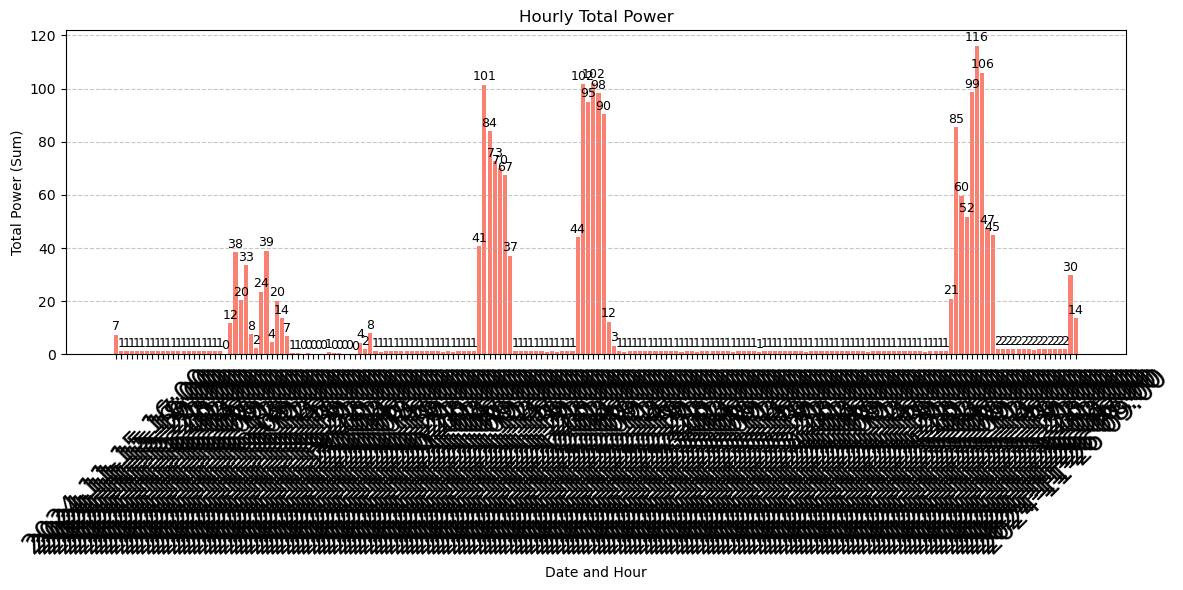

In [82]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert to datetime if not already
analysis_data = final_merged_data

# Extract date and hour for grouping
analysis_data['date_and_hour'] = analysis_data['ISO_formatted_datetime'].dt.strftime('%Y-%m-%d %H:00')

# Group by date and hour and calculate total power and average energy
values = analysis_data.groupby('date_and_hour')['total_power'].sum()
energy_values = analysis_data.groupby('date_and_hour')['total_energy'].mean()

# Prepare data for plotting
categories = values.index
sum_values = values.values

# Plot the bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(categories, sum_values, color='salmon')

# Add grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate each bar with its height
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5,  # Position above the bar
             f'{height:.0f}',  # Format value as an integer
             ha='center', va='bottom', fontsize=9, color='black')

# Add labels and title
plt.xlabel('Date and Hour')
plt.ylabel('Total Power (Sum)')
plt.title('Hourly Total Power')

# Improve x-axis readability
plt.xticks(rotation=45, fontsize=20)

# Adjust layout to prevent label overlap
plt.tight_layout()
plt.show()
